In [1]:
import concurrent.futures

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# metrics
from sklearn.metrics import *

# visuals.
import seaborn as sns

In [2]:
trades = pd.read_csv("./trades/ARK_Trade_02012021_0619PM_EST_601875e069e08.csv").dropna(how='all')
trades.rename({"FUND":"etf", "Direction":"direction", "Ticker":"symbol", "% of ETF":"pct_etf"}, axis=1, inplace=True)
trades.head(3)

,etf,Date,direction,symbol,CUSIP,Name,Shares,pct_etf
0,ARKQ,2021-02-01,Buy,LMT,539830109,LOCKHEED MARTIN CORP,47673.0,0.5146
1,ARKQ,2021-02-01,Buy,NVDA,67066G104,NVIDIA CORP,28521.0,0.5020
2,ARKW,2021-02-01,Buy,DKNG,26142R104,DRAFTKINGS INC,620300.0,0.5007


In [3]:
configs = [{"symbol":symbol, "start":"2021-02-01", "end":"2021-02-02", "on":"Adj Close"} for symbol in trades["symbol"].unique()]

def parallel_fetch_daily_data(config):
    # fetch daily market data from yahoo finance
    df = web.get_data_yahoo(config["symbol"], config["start"], config["end"])[[config["on"]]]
    df["symbol"] = config["symbol"]
    return df


prices = [] # list of dfs
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    prices.extend(executor.map(parallel_fetch_daily_data, configs))
prices = pd.concat(prices)
prices.head()

,Adj Close,symbol
Date,,
2021-02-01,324.029999,LMT
2021-02-02,332.700012,LMT
2021-02-01,529.479980,NVDA
2021-02-02,542.270020,NVDA
2021-02-01,54.639999,DKNG


In [4]:
returns = [] # actual price changes
gg = prices.groupby("symbol")
for g in gg.groups:
    gdf = gg.get_group(g)
    symbol_return = gdf["Adj Close"].pct_change().loc["2021-02-02"]
    returns.append({
        "symbol":g,
        "return":symbol_return,
        "direction":"Buy" if symbol_return>0 else "Sell"
    })
returns = pd.DataFrame(returns)
returns.head()

,symbol,return,direction
0,API,0.017255,Buy
1,AVAV,0.000422,Buy
2,BEAM,0.006609,Buy
3,BEKE,0.058717,Buy
4,BYDDY,0.073406,Buy


In [5]:
trades_sginal = [] # signals based on ARK trades
tgg = trades.groupby("symbol")
for g in tgg.groups:
    gdf = tgg.get_group(g)
    trades_sginal.append({
        "symbol":g,
        "direction":gdf["direction"].mode()[0]
    })
trades_sginal = pd.DataFrame(trades_sginal)
trades_sginal.head()

,symbol,direction
0,API,Sell
1,AVAV,Sell
2,BEAM,Buy
3,BEKE,Buy
4,BYDDY,Sell


In [6]:
trades_sginal.sort_values("symbol", inplace=True)
returns.sort_values("symbol", inplace=True)
if set(trades_sginal["symbol"]) != set(returns["symbol"]):
    raise ValueError("symbols do not match")
    
actual = np.array(returns["direction"])
signal = np.array(trades_sginal["direction"])

print(classification_report(actual, signal))

              precision    recall  f1-score   support

         Buy       1.00      0.43      0.61        23
        Sell       0.24      1.00      0.38         4

    accuracy                           0.52        27
   macro avg       0.62      0.72      0.49        27
weighted avg       0.89      0.52      0.57        27



In [7]:
joined = pd.merge(trades, returns, on="symbol", suffixes=("_signal", "_return"))
joined["pct_etf"] = joined.apply(lambda row : row["pct_etf"] if row["direction_signal"]=="Buy" else -row["pct_etf"], axis=1)
joined.head()

,etf,Date,direction_signal,symbol,CUSIP,Name,Shares,pct_etf,return,direction_return
0,ARKQ,2021-02-01,Buy,LMT,539830109,LOCKHEED MARTIN CORP,47673.0,0.5146,0.026757,Buy
1,ARKQ,2021-02-01,Buy,NVDA,67066G104,NVIDIA CORP,28521.0,0.5020,0.024156,Buy
2,ARKW,2021-02-01,Buy,NVDA,67066G104,NVIDIA CORP,64133.0,0.4975,0.024156,Buy
3,ARKW,2021-02-01,Buy,DKNG,26142R104,DRAFTKINGS INC,620300.0,0.5007,0.085469,Buy
4,ARKW,2021-02-01,Sell,ROKU,77543R102,ROKU INC,73244.0,-0.4403,0.006127,Buy


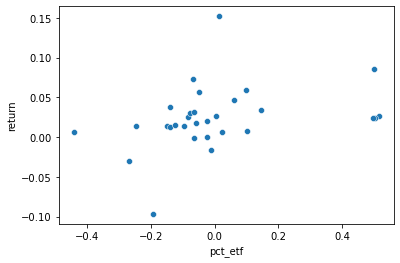

In [8]:
sns.scatterplot(x=joined["pct_etf"], y=joined["return"])

In [9]:
joined.corr()

,Shares,pct_etf,return
Shares,1.000000,0.243674,0.217546
pct_etf,0.243674,1.000000,0.321216
return,0.217546,0.321216,1.000000
